Entrene una red convolucional para clasificar las imágenes de la base de datos MNIST.

¿Cuál es la red convolucional más pequeña que puede conseguir con una exactitud de al menos 90% en el conjunto de evaluación? ¿Cuál es el perceptrón multicapa más pequeño que puede conseguir con la misma exactitud?

En este caso se nos permitió usar Pytorch para la parte de código. La idea es definir la estructura general de la red y luego ir modificandola hasta lograr la mejor performance. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

# Elegir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transformación
transform = transforms.ToTensor()

# Dataset MNIST
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# minibatch
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

Device: cpu


Primero una función que entrena y grafica

In [2]:
def train_and_evaluate(model, train_loader, test_loader,
                       criterion, optimizer, device,
                       num_epochs=50, patience=5, min_delta=1e-4):
    
    model = model.to(device)
    best_loss = float("inf")
    epochs_no_improve = 0
    
    history = {"train_loss": [], "test_loss": [], "accuracy": []}

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f"Parámetros entrenables: {total_params:,}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for x,y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Evaluación
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for x,y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                test_loss += criterion(outputs, y).item()
                _, pred = outputs.max(1)
                total += y.size(0)
                correct += pred.eq(y).sum().item()

        test_loss /= len(test_loader)
        accuracy = 100 * correct / total

        history["test_loss"].append(test_loss)
        history["accuracy"].append(accuracy)

        print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | "
              f"Test Loss {test_loss:.4f} | Acc {accuracy:.2f}%")

        # Early stopping
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("✔ Early stopping activado")
            break

    # Gráficos
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["test_loss"], label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["accuracy"], label="Accuracy")
    plt.title("Accuracy (%)")
    plt.legend()
    plt.show()

    return history


La primer estructura que quiero hacer es algo muy simple, una red convolucional pegada a una fully connected, bien simple. 

CNN_Mini(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)
Parámetros entrenables: 11,738
Epoch 1 | Train Loss 0.3181 | Test Loss 0.1156 | Acc 96.68%
Epoch 2 | Train Loss 0.1001 | Test Loss 0.0733 | Acc 97.81%
Epoch 3 | Train Loss 0.0744 | Test Loss 0.0748 | Acc 97.42%
Epoch 4 | Train Loss 0.0624 | Test Loss 0.0565 | Acc 98.12%
Epoch 5 | Train Loss 0.0544 | Test Loss 0.0518 | Acc 98.40%
Epoch 6 | Train Loss 0.0493 | Test Loss 0.0490 | Acc 98.35%
Epoch 7 | Train Loss 0.0453 | Test Loss 0.0570 | Acc 98.17%
Epoch 8 | Train Loss 0.0416 | Test Loss 0.0493 | Acc 98.45%
Epoch 9 | Train Loss 0.0380 | Test Loss 0.0502 | Acc 98.42%
Epoch 10 | Train Loss 0.0359 | Test Loss 0.0486 | Acc 98.48%
Epoch 11 | Train Loss 0.0335 | Test Loss 0.0514 | Acc 98.41%
Epoch 12 | Train Loss 0.0315 | Test Loss 0.0564 | Acc 98.37%
Epoch 13 | Train Loss 0.0298 

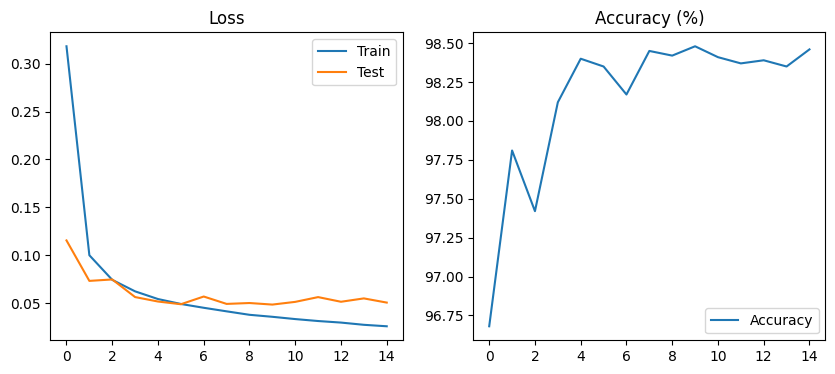

In [3]:
class CNN_Mini(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(8*12*12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


CNN_Mini(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=720, out_features=10, bias=True)
)
Parámetros entrenables: 7,340
Epoch 1 | Train Loss 0.4455 | Test Loss 0.2806 | Acc 91.80%
Epoch 2 | Train Loss 0.2562 | Test Loss 0.1988 | Acc 94.13%
Epoch 3 | Train Loss 0.1716 | Test Loss 0.1339 | Acc 96.28%
Epoch 4 | Train Loss 0.1206 | Test Loss 0.1017 | Acc 97.00%
Epoch 5 | Train Loss 0.0957 | Test Loss 0.0813 | Acc 97.47%
Epoch 6 | Train Loss 0.0800 | Test Loss 0.0731 | Acc 97.78%
Epoch 7 | Train Loss 0.0704 | Test Loss 0.0657 | Acc 97.90%
Epoch 8 | Train Loss 0.0635 | Test Loss 0.0603 | Acc 98.03%
Epoch 9 | Train Loss 0.0587 | Test Loss 0.0582 | Acc 98.24%
Epoch 10 | Train Loss 0.0528 | Test Loss 0.0566 | Acc 98.21%
Epoch 11 | Train Loss 0.0498 | Test Loss 0.0544 | Acc 98.28%
Epoch 12 | Train Loss 0.0475 | Test Loss 0.0541 | Acc 98.34%
Epoch 13 | Train Loss 0.0454 | 

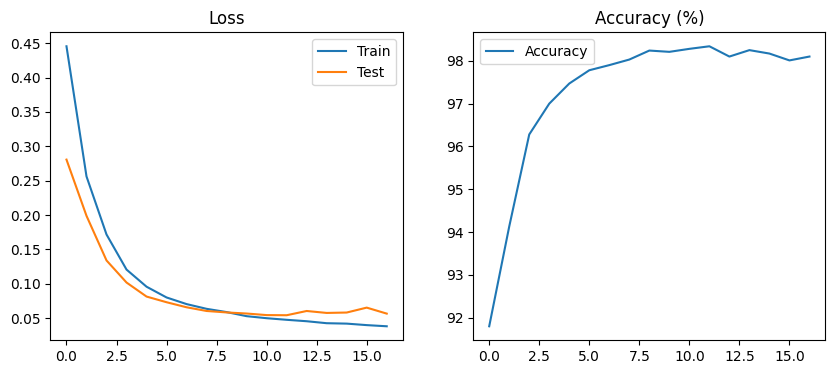

In [5]:
class CNN_Mini(nn.Module):
    def __init__(self):
        #28 × 28 × 1 entrada mnist
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5) # le bajo la cantidad de planos de features a extraer (28 − 5 + 1 = 24 nuevo tamaño)
        self.pool = nn.MaxPool2d(2,2) # 24 / 2 = 12
        self.fc = nn.Linear(5*12*12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


CNN_Mini(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=288, out_features=10, bias=True)
)
Parámetros entrenables: 2,942
Epoch 1 | Train Loss 0.5030 | Test Loss 0.2853 | Acc 91.77%
Epoch 2 | Train Loss 0.2742 | Test Loss 0.2263 | Acc 93.58%
Epoch 3 | Train Loss 0.2140 | Test Loss 0.1753 | Acc 95.14%
Epoch 4 | Train Loss 0.1692 | Test Loss 0.1432 | Acc 95.94%
Epoch 5 | Train Loss 0.1433 | Test Loss 0.1245 | Acc 96.44%
Epoch 6 | Train Loss 0.1287 | Test Loss 0.1174 | Acc 96.57%
Epoch 7 | Train Loss 0.1190 | Test Loss 0.1118 | Acc 96.65%
Epoch 8 | Train Loss 0.1136 | Test Loss 0.1070 | Acc 96.84%
Epoch 9 | Train Loss 0.1096 | Test Loss 0.1039 | Acc 96.92%
Epoch 10 | Train Loss 0.1051 | Test Loss 0.1045 | Acc 96.79%
Epoch 11 | Train Loss 0.1017 | Test Loss 0.1021 | Acc 96.81%
Epoch 12 | Train Loss 0.0995 | Test Loss 0.0990 | Acc 96.99%
Epoch 13 | Train Loss 0.0976 | 

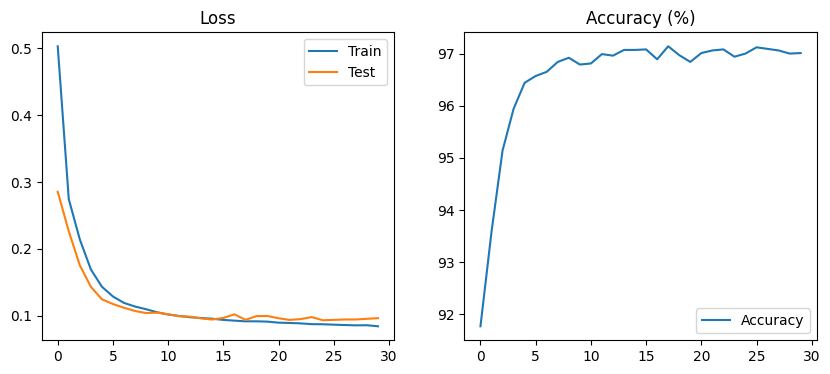

In [6]:
class CNN_Mini(nn.Module):
    def __init__(self):
        #28 × 28 × 1 entrada mnist
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5) # le bajo la cantidad de planos de features a extraer (28 − 5 + 1 = 24 nuevo tamaño)
        self.pool = nn.MaxPool2d(2,2) # 24 / 2 = 12
        self.fc = nn.Linear(2*12*12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


CNN_Mini(
  (conv1): Conv2d(1, 2, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)
Parámetros entrenables: 2,174
Epoch 1 | Train Loss 0.5176 | Test Loss 0.2793 | Acc 92.21%
Epoch 2 | Train Loss 0.2450 | Test Loss 0.1859 | Acc 94.50%
Epoch 3 | Train Loss 0.1814 | Test Loss 0.1440 | Acc 95.55%
Epoch 4 | Train Loss 0.1487 | Test Loss 0.1191 | Acc 96.42%
Epoch 5 | Train Loss 0.1317 | Test Loss 0.1145 | Acc 96.47%
Epoch 6 | Train Loss 0.1212 | Test Loss 0.1032 | Acc 96.73%
Epoch 7 | Train Loss 0.1135 | Test Loss 0.1100 | Acc 96.65%
Epoch 8 | Train Loss 0.1101 | Test Loss 0.0999 | Acc 96.86%
Epoch 9 | Train Loss 0.1055 | Test Loss 0.0957 | Acc 97.02%
Epoch 10 | Train Loss 0.1029 | Test Loss 0.0921 | Acc 97.04%
Epoch 11 | Train Loss 0.1006 | Test Loss 0.0938 | Acc 96.88%
Epoch 12 | Train Loss 0.0990 | Test Loss 0.0930 | Acc 97.10%
Epoch 13 | Train Loss 0.0976 | 

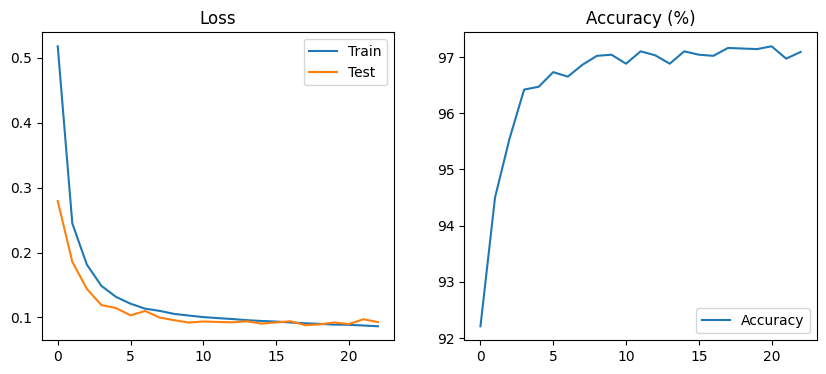

In [7]:
class CNN_Mini(nn.Module):
    def __init__(self):
        #28 × 28 × 1 entrada mnist
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=9) # le bajo la cantidad de planos de features a extraer (28 − 9 + 1 = 20 nuevo tamaño)
        self.pool = nn.MaxPool2d(2,2) # 20 / 2 = 10
        self.fc = nn.Linear(2*10*10, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


CNN_Mini(
  (conv1): Conv2d(1, 2, kernel_size=(15, 15), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=98, out_features=10, bias=True)
)
Parámetros entrenables: 1,442
Epoch 1 | Train Loss 0.5428 | Test Loss 0.3005 | Acc 91.28%
Epoch 2 | Train Loss 0.2831 | Test Loss 0.2464 | Acc 92.91%
Epoch 3 | Train Loss 0.2395 | Test Loss 0.2187 | Acc 93.62%
Epoch 4 | Train Loss 0.2170 | Test Loss 0.2065 | Acc 93.69%
Epoch 5 | Train Loss 0.2023 | Test Loss 0.1952 | Acc 94.54%
Epoch 6 | Train Loss 0.1922 | Test Loss 0.1805 | Acc 94.66%
Epoch 7 | Train Loss 0.1853 | Test Loss 0.1773 | Acc 94.81%
Epoch 8 | Train Loss 0.1789 | Test Loss 0.1856 | Acc 94.53%
Epoch 9 | Train Loss 0.1747 | Test Loss 0.1736 | Acc 94.92%
Epoch 10 | Train Loss 0.1703 | Test Loss 0.1728 | Acc 94.93%
Epoch 11 | Train Loss 0.1678 | Test Loss 0.1736 | Acc 94.77%
Epoch 12 | Train Loss 0.1645 | Test Loss 0.1698 | Acc 94.83%
Epoch 13 | Train Loss 0.1630 |

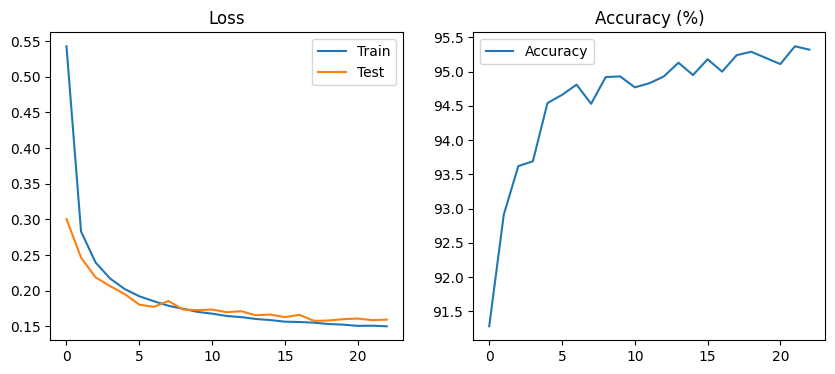

In [ ]:
class CNN_Mini(nn.Module):
    def __init__(self):
        #28 × 28 × 1 entrada mnist
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=15) # le bajo la cantidad de planos de features a extraer (28 − 15 + 1 = 14 nuevo tamaño)
        self.pool = nn.MaxPool2d(2,2) # 20 / 2 = 10
        self.fc = nn.Linear(2*7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


CNN_Mini(
  (conv1): Conv2d(1, 2, kernel_size=(15, 15), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=18, out_features=10, bias=True)
)
Parámetros entrenables: 642
Epoch 1 | Train Loss 0.9824 | Test Loss 0.5665 | Acc 82.90%
Epoch 2 | Train Loss 0.5448 | Test Loss 0.4756 | Acc 85.76%
Epoch 3 | Train Loss 0.4832 | Test Loss 0.4394 | Acc 87.09%
Epoch 4 | Train Loss 0.4482 | Test Loss 0.4075 | Acc 87.70%
Epoch 5 | Train Loss 0.4223 | Test Loss 0.3950 | Acc 87.86%
Epoch 6 | Train Loss 0.4038 | Test Loss 0.3723 | Acc 88.60%
Epoch 7 | Train Loss 0.3888 | Test Loss 0.3650 | Acc 88.95%
Epoch 8 | Train Loss 0.3760 | Test Loss 0.3532 | Acc 89.10%
Epoch 9 | Train Loss 0.3667 | Test Loss 0.3450 | Acc 89.82%
Epoch 10 | Train Loss 0.3578 | Test Loss 0.3368 | Acc 89.64%
Epoch 11 | Train Loss 0.3520 | Test Loss 0.3291 | Acc 90.06%
Epoch 12 | Train Loss 0.3458 | Test Loss 0.3253 | Acc 90.13%
Epoch 13 | Train Loss 0.3398 | T

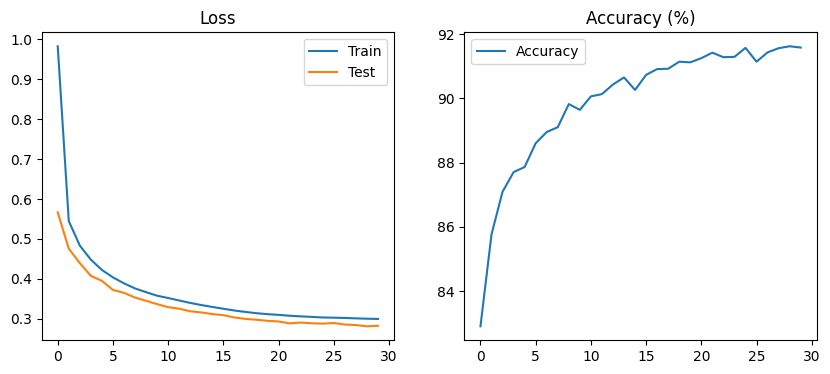

In [3]:
class CNN_Mini(nn.Module):
    def __init__(self):
        #28 × 28 × 1 entrada mnist
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=15) # 28-15+1=14
        self.pool = nn.MaxPool2d(4,4)                 # 14/4=3.5 → PyTorch redondea a 3
        self.fc = nn.Linear(2*3*3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model_cnn = CNN_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

history_cnn = train_and_evaluate(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


Este es de un MLP

MLP_Mini(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
Parámetros entrenables: 50,890
Epoch 1 | Train Loss 0.3905 | Test Loss 0.2162 | Acc 93.77%
Epoch 2 | Train Loss 0.1885 | Test Loss 0.1580 | Acc 95.23%
Epoch 3 | Train Loss 0.1414 | Test Loss 0.1406 | Acc 95.97%
Epoch 4 | Train Loss 0.1127 | Test Loss 0.1153 | Acc 96.50%
Epoch 5 | Train Loss 0.0928 | Test Loss 0.1061 | Acc 96.68%
Epoch 6 | Train Loss 0.0790 | Test Loss 0.0979 | Acc 97.03%
Epoch 7 | Train Loss 0.0671 | Test Loss 0.0908 | Acc 97.31%
Epoch 8 | Train Loss 0.0591 | Test Loss 0.0881 | Acc 97.35%
Epoch 9 | Train Loss 0.0509 | Test Loss 0.0952 | Acc 97.14%
Epoch 10 | Train Loss 0.0450 | Test Loss 0.0832 | Acc 97.55%
Epoch 11 | Train Loss 0.0402 | Test Loss 0.0939 | Acc 97.28%
Epoch 12 | Train Loss 0.0345 | Test Loss 0.0832 | Acc 97.48%
Epoch 13 | Train Loss 0.0305 | Test Loss 0.0858 | Acc 97.55%
Epoch 14 | Train Loss 0.0268 | Test Loss 0.0868 | Ac

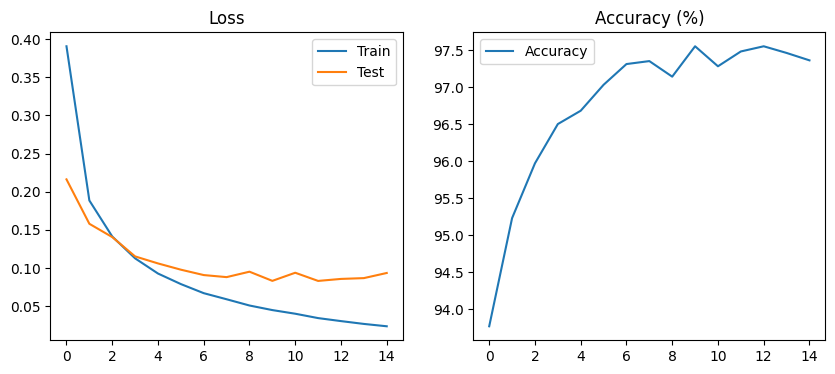

In [4]:
class MLP_Mini(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model_mlp = MLP_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

history_mlp = train_and_evaluate(
    model_mlp, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


MLP_Mini(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
Parámetros entrenables: 7,850
Epoch 1 | Train Loss 0.5413 | Test Loss 0.3328 | Acc 91.11%
Epoch 2 | Train Loss 0.3231 | Test Loss 0.2931 | Acc 91.86%
Epoch 3 | Train Loss 0.2952 | Test Loss 0.2783 | Acc 92.29%
Epoch 4 | Train Loss 0.2818 | Test Loss 0.2730 | Acc 92.39%
Epoch 5 | Train Loss 0.2733 | Test Loss 0.2694 | Acc 92.53%
Epoch 6 | Train Loss 0.2676 | Test Loss 0.2703 | Acc 92.48%
Epoch 7 | Train Loss 0.2635 | Test Loss 0.2648 | Acc 92.65%
Epoch 8 | Train Loss 0.2602 | Test Loss 0.2664 | Acc 92.51%
Epoch 9 | Train Loss 0.2570 | Test Loss 0.2618 | Acc 92.81%
Epoch 10 | Train Loss 0.2546 | Test Loss 0.2636 | Acc 92.62%
Epoch 11 | Train Loss 0.2525 | Test Loss 0.2648 | Acc 92.57%
Epoch 12 | Train Loss 0.2509 | Test Loss 0.2623 | Acc 92.62%
Epoch 13 | Train Loss 0.2496 | Test Loss 0.2608 | Acc 92.83%
Epoch 14 | Train Loss 0.2478 | Test Loss 0.2618 | Acc 92.83%
Epoch 15 | Train Loss 0.2463 | Test Loss 0.2637 | Acc

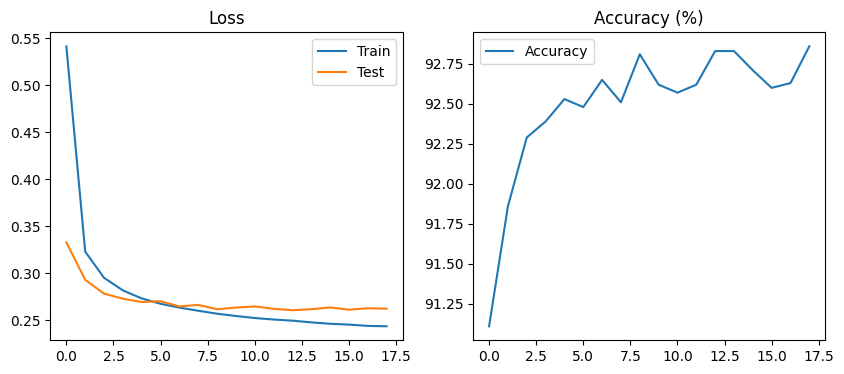

In [9]:
class MLP_Mini(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10) # lo más barebones que se podría hacer sin pooling

    def forward(self, x):
        x = torch.flatten(x, 1)  # aplana de (N, 1, 28, 28) a (N, 784)
        x = self.fc(x)           # sin ReLU, directamente a 10 clases
        return x # no se hace una relu porque se aplica sola para la última capa, un softmax para la crossEntropy

model_mlp = MLP_Mini()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

history_mlp = train_and_evaluate(
    model_mlp, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)


MLP_WithPooling(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=196, out_features=10, bias=True)
)
Parámetros entrenables: 1,970
Epoch 1 | Train Loss 0.8563 | Test Loss 0.4823 | Acc 88.36%
Epoch 2 | Train Loss 0.4360 | Test Loss 0.3801 | Acc 89.89%
Epoch 3 | Train Loss 0.3726 | Test Loss 0.3415 | Acc 90.68%
Epoch 4 | Train Loss 0.3449 | Test Loss 0.3223 | Acc 91.13%
Epoch 5 | Train Loss 0.3287 | Test Loss 0.3119 | Acc 91.35%
Epoch 6 | Train Loss 0.3184 | Test Loss 0.3014 | Acc 91.53%
Epoch 7 | Train Loss 0.3112 | Test Loss 0.2966 | Acc 91.58%
Epoch 8 | Train Loss 0.3056 | Test Loss 0.2939 | Acc 91.68%
Epoch 9 | Train Loss 0.3015 | Test Loss 0.2913 | Acc 91.58%
Epoch 10 | Train Loss 0.2981 | Test Loss 0.2874 | Acc 91.54%
Epoch 11 | Train Loss 0.2952 | Test Loss 0.2866 | Acc 91.77%
Epoch 12 | Train Loss 0.2929 | Test Loss 0.2842 | Acc 91.71%
Epoch 13 | Train Loss 0.2907 | Test Loss 0.2813 | Acc 91.88%
Epoch 14 | Train Loss 

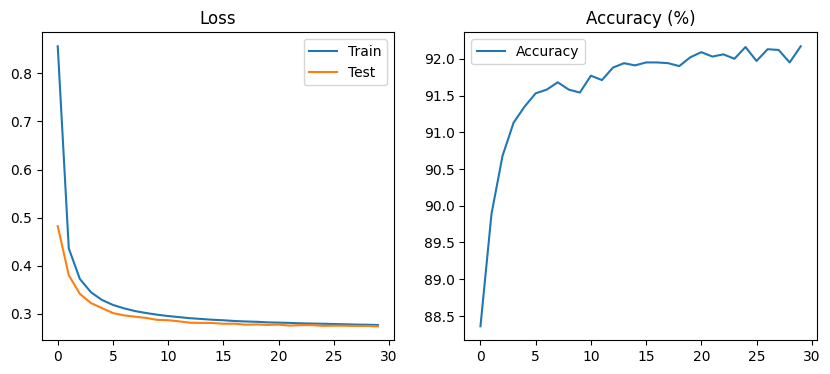

In [4]:
class MLP_WithPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)           # reduce resolución a la mitad
        self.fc = nn.Linear(14*14, 10)           # 28x28 → 14x14 → 196 entradas

    def forward(self, x):
        x = self.pool(x)                         # hace max pooling 2x2
        x = torch.flatten(x, 1)                  # aplana para FC
        x = self.fc(x)                           # salida 10 clases
        return x

model_mlp = MLP_WithPooling()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

history_mlp = train_and_evaluate(
    model_mlp, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=30, patience=5
)
